In [70]:
!pip install pyspark folium


import os
import json
import gc
import zipfile
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans as SklearnKMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import folium
from folium.plugins import HeatMap, MarkerCluster


from pyspark.sql import SparkSession

from pyspark.sql.functions import (
    col, to_timestamp, hour, dayofweek, month,
    avg, count, log1p, date_format, when, lit,
    radians as to_radians,
    degrees as to_degrees,
    sin, cos, atan2, sqrt, pow,
    abs as spark_abs,
    expm1
)


from pyspark.sql.types import DoubleType, IntegerType
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, VectorSlicer
from pyspark.ml.clustering import KMeans
from pyspark.ml.regression import GBTRegressor, LinearRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.stat import Correlation
import warnings
warnings.filterwarnings('ignore')

# Setting Tampilan
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

print("✅ Environment Kaggle Siap & Library Terinstall!")

✅ Environment Kaggle Siap & Library Terinstall!


In [74]:
# Inisialisasi Spark

print("🔄 Menjalankan Spark Session...")
spark = SparkSession.builder \
    .appName("NYCTaxi_Full") \
    .config("spark.driver.memory", "12g") \
    .getOrCreate()
print("✅ Spark Session Berhasil!")

🔄 Menjalankan Spark Session...
✅ Spark Session Berhasil!


### 1. Load Data

In [75]:
import os
import zipfile

print("\n📂 Menyiapkan Data (Train & Test)...")

# Daftar file yang mau diproses
files = ['train', 'test']
working_dir = '/kaggle/working/'

for name in files:
    input_zip = f'/kaggle/input/nyc-taxi-trip-duration/{name}.zip'
    working_csv = f'/kaggle/working/{name}.csv'

    # Ekstraksi Data
    if os.path.exists(input_zip) and not os.path.exists(working_csv):
        print(f"   - Mengekstrak {name}.zip...")
        with zipfile.ZipFile(input_zip, 'r') as z:
            z.extractall(working_dir)
        print(f"   ✅ {name} Ekstraksi Selesai.")

    elif not os.path.exists(working_csv):
        print(f"   ⚠️ {name}.zip tidak ditemukan di Input. Mencoba download via API...")
        os.system("kaggle competitions download -c nyc-taxi-trip-duration")
        os.system("unzip -q nyc-taxi-trip-duration.zip")
        os.system(f"unzip -q {name}.zip")

# Load Data ke Spark
print("\n⏳ Loading ke Spark DataFrame...")

# Load Train
if os.path.exists(f'{working_dir}train.csv'):
    df = spark.read.csv(f'{working_dir}train.csv', header=True, inferSchema=True)
    print(f"✅ DF Train Loaded: {df.count():,} baris.")
else:
    raise FileNotFoundError("❌ File train.csv gagal dimuat!")

# Load Test
if os.path.exists(f'{working_dir}test.csv'):
    df_test = spark.read.csv(f'{working_dir}test.csv', header=True, inferSchema=True)
    print(f"✅ DF Test Loaded : {df_test.count():,} baris.")
else:
    raise FileNotFoundError("❌ File test.csv gagal dimuat!")

print("\n🚀 Semua data siap digunakan!")


📂 Menyiapkan Data (Train & Test)...

⏳ Loading ke Spark DataFrame...


✅ DF Train Loaded: 1,458,644 baris.


✅ DF Test Loaded : 625,134 baris.

🚀 Semua data siap digunakan!


In [76]:
# Caching agar proses selanjutnya lebih cepat
df.cache()

print(f"Total Baris Data Awal: {df.count()}")
df.printSchema()

Total Baris Data Awal: 1458644
root
 |-- id: string (nullable = true)
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: integer (nullable = true)



### 2. Data Cleaning & Preprocessing

In [77]:
# Konversi string ke timestamp
df = df.withColumn("pickup_datetime", to_timestamp(col("pickup_datetime"))) \
       .withColumn("dropoff_datetime", to_timestamp(col("dropoff_datetime")))

# Cek hasil konversi
df.select("pickup_datetime", "dropoff_datetime").show(5)

+-------------------+-------------------+
|    pickup_datetime|   dropoff_datetime|
+-------------------+-------------------+
|2016-03-14 17:24:55|2016-03-14 17:32:30|
|2016-06-12 00:43:35|2016-06-12 00:54:38|
|2016-01-19 11:35:24|2016-01-19 12:10:48|
|2016-04-06 19:32:31|2016-04-06 19:39:40|
|2016-03-26 13:30:55|2016-03-26 13:38:10|
+-------------------+-------------------+
only showing top 5 rows



In [78]:
initial_count = df.count()

# Hapus duplikat
df = df.dropDuplicates()
print(f'Jumlah duplikat yang dibuang: {initial_count - df.count()}')

# Hapus Null values
df = df.na.drop()
print("Null values dibersihkan.")

Jumlah duplikat yang dibuang: 0
Null values dibersihkan.


In [79]:
# Hitung durasi dalam menit
df = df.withColumn("trip_duration_minutes", col("trip_duration") / 60)

# Statistik sebelum filter
print("Statistik Durasi (Menit) Sebelum Filter:")
df.select("trip_duration_minutes").describe().show()

# Filter Durasi (1 menit s/d 120 menit)
df = df.filter((col("trip_duration_minutes") >= 1) & (col("trip_duration_minutes") <= 120))

# Filter Penumpang (1 - 6 orang)
df = df.filter((col("passenger_count") >= 1) & (col("passenger_count") <= 6))

print(f"Sisa data setelah filter durasi & penumpang: {df.count()}")

Statistik Durasi (Menit) Sebelum Filter:


+-------+---------------------+
|summary|trip_duration_minutes|
+-------+---------------------+
|  count|              1458644|
|   mean|   15.991537882672606|
| stddev|    87.29052874162763|
|    min| 0.016666666666666666|
|    max|    58771.36666666667|
+-------+---------------------+



Sisa data setelah filter durasi & penumpang: 1447777


In [ ]:
print("--- [4] Filter Area Koordinat (NYC) ---")

# Batas koordinat NYC
lat_min, lat_max = 40.5, 41.0
lon_min, lon_max = -74.5, -73.0

df = df.filter(
    (col('pickup_latitude').between(lat_min, lat_max)) &
    (col('dropoff_latitude').between(lat_min, lat_max)) &
    (col('pickup_longitude').between(lon_min, lon_max)) &
    (col('dropoff_longitude').between(lon_min, lon_max))
)

# Hapus data dimana pickup == dropoff (diam di tempat)
df = df.filter(~((col('pickup_longitude') == col('dropoff_longitude')) &
                 (col('pickup_latitude') == col('dropoff_latitude'))))

print("Filter area selesai.")

--- [4] Filter Area Koordinat (NYC) ---
Filter area selesai.


In [81]:
# Fungsi Haversine
def spark_haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius Bumi (km)
    # Konversi ke radian
    lat1, lon1, lat2, lon2 = to_radians(lat1), to_radians(lon1), to_radians(lat2), to_radians(lon2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = pow(sin(dlat / 2), 2) + cos(lat1) * cos(lat2) * pow(sin(dlon / 2), 2)
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Terapkan fungsi
df = df.withColumn("distance_km", spark_haversine(
    col("pickup_latitude"), col("pickup_longitude"),
    col("dropoff_latitude"), col("dropoff_longitude")
))

# Hitung Kecepatan Rata-rata (km/h)
df = df.withColumn("avg_speed_kmh", col("distance_km") / (col("trip_duration_minutes") / 60))

# Filter Jarak (0.5km - 30km) & Kecepatan (0.5 - 120 km/h)
df = df.filter((col("distance_km") >= 0.5) & (col("distance_km") <= 30))
df = df.filter((col("avg_speed_kmh") > 0.5) & (col("avg_speed_kmh") <= 120))

print(f'✅ Data shape setelah cleaning total: {df.count()} baris')

✅ Data shape setelah cleaning total: 1406483 baris


### 3. EDA

(0.0, 120.0)

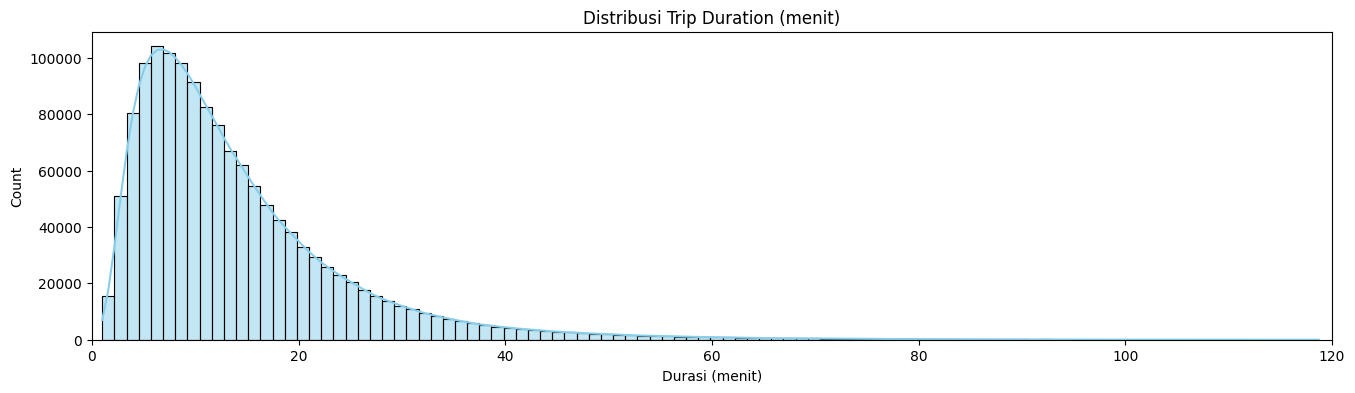

In [10]:
dur_dist_pd = df.select("trip_duration_minutes", "distance_km").toPandas()

plt.figure(figsize=(16, 4))

sns.histplot(dur_dist_pd['trip_duration_minutes'], bins=100, kde=True, color='skyblue')
plt.title('Distribusi Trip Duration (menit)')
plt.xlabel('Durasi (menit)')
plt.xlim(0, 120)

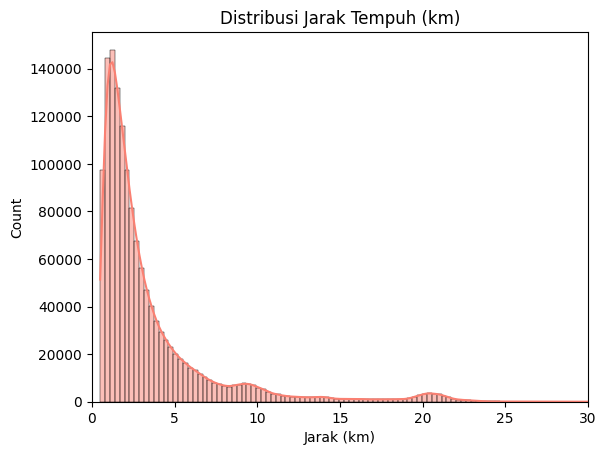

231

In [11]:
sns.histplot(dur_dist_pd['distance_km'], bins=100, kde=True, color='salmon')
plt.title('Distribusi Jarak Tempuh (km)')
plt.xlabel('Jarak (km)')
plt.xlim(0, 30)

plt.show()

# Hapus variabel pandas untuk hemat memori
del dur_dist_pd
gc.collect()

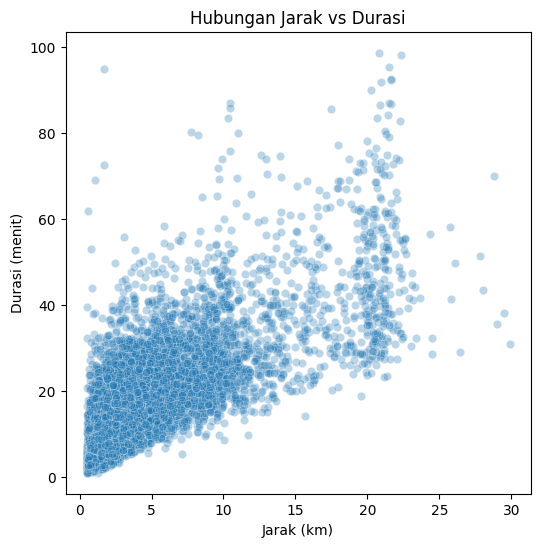

In [12]:
# Sample sekitar 14,000 data (14,000 / 1.4jt ~= 0.01)
scatter_pd = df.select("distance_km", "trip_duration_minutes").sample(withReplacement=False, fraction=0.01, seed=42).toPandas()

plt.figure(figsize=(6, 6))
sns.scatterplot(x='distance_km', y='trip_duration_minutes', data=scatter_pd, alpha=0.3)
plt.title('Hubungan Jarak vs Durasi')
plt.xlabel('Jarak (km)')
plt.ylabel('Durasi (menit)')
plt.show()

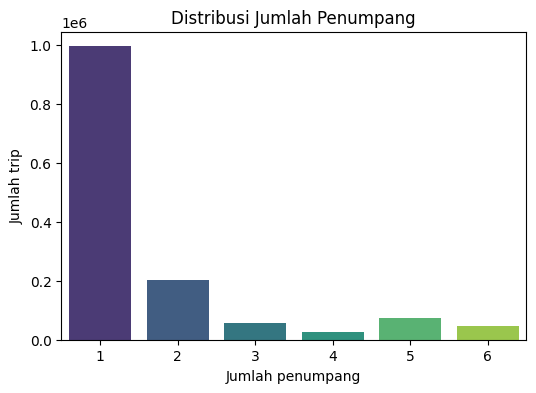

In [13]:
pass_counts = df.groupBy("passenger_count").count().orderBy("passenger_count").toPandas()

plt.figure(figsize=(6, 4))
sns.barplot(x='passenger_count', y='count', data=pass_counts, palette='viridis')
plt.title('Distribusi Jumlah Penumpang')
plt.xlabel('Jumlah penumpang')
plt.ylabel('Jumlah trip')
plt.show()

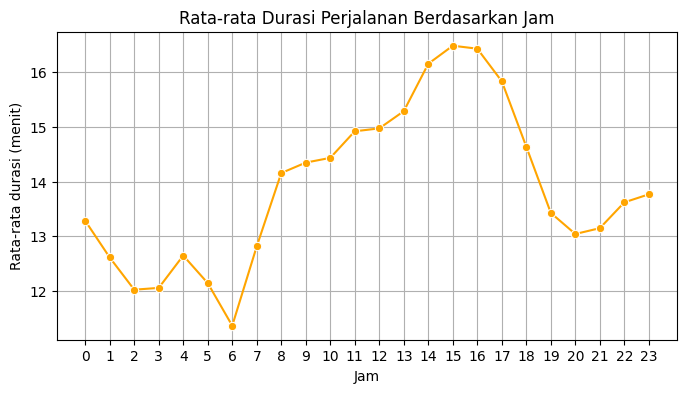

In [14]:
from pyspark.sql.functions import hour, col

df = df.withColumn("pickup_hour", hour(col("pickup_datetime")))

hourly_mean = df.groupBy("pickup_hour") \
    .agg(avg("trip_duration_minutes").alias("mean_duration")) \
    .orderBy("pickup_hour") \
    .toPandas()

plt.figure(figsize=(8, 4))
sns.lineplot(x=hourly_mean['pickup_hour'], y=hourly_mean['mean_duration'], marker='o', color='orange')
plt.title('Rata-rata Durasi Perjalanan Berdasarkan Jam')
plt.xlabel('Jam')
plt.ylabel('Rata-rata durasi (menit)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

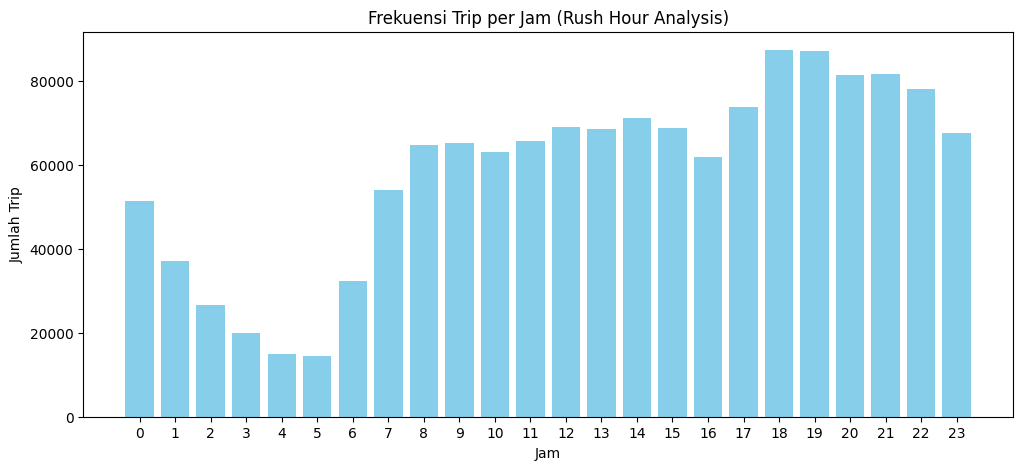

In [15]:
freq_per_hour = df.groupBy("pickup_hour").count().orderBy("pickup_hour").toPandas()

plt.figure(figsize=(12, 5))
plt.bar(freq_per_hour['pickup_hour'], freq_per_hour['count'], color='skyblue')
plt.title("Frekuensi Trip per Jam (Rush Hour Analysis)")
plt.xlabel("Jam")
plt.ylabel("Jumlah Trip")
plt.xticks(range(0, 24))
plt.show()

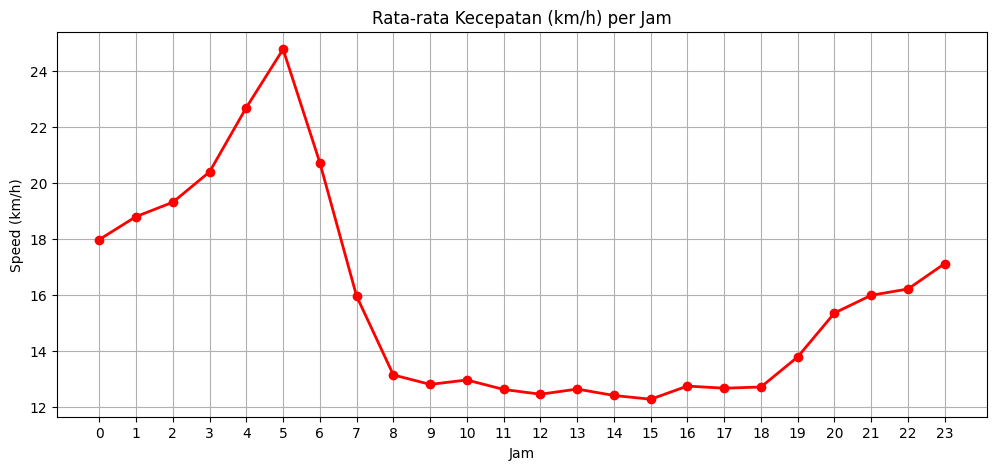

In [16]:
avg_speed_hour = df.groupBy("pickup_hour").agg(avg("avg_speed_kmh").alias("mean_speed")) \
                   .orderBy("pickup_hour").toPandas()

plt.figure(figsize=(12, 5))
plt.plot(avg_speed_hour['pickup_hour'], avg_speed_hour['mean_speed'], marker='o', color='red', linewidth=2)
plt.title("Rata-rata Kecepatan (km/h) per Jam")
plt.xlabel("Jam")
plt.ylabel("Speed (km/h)")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

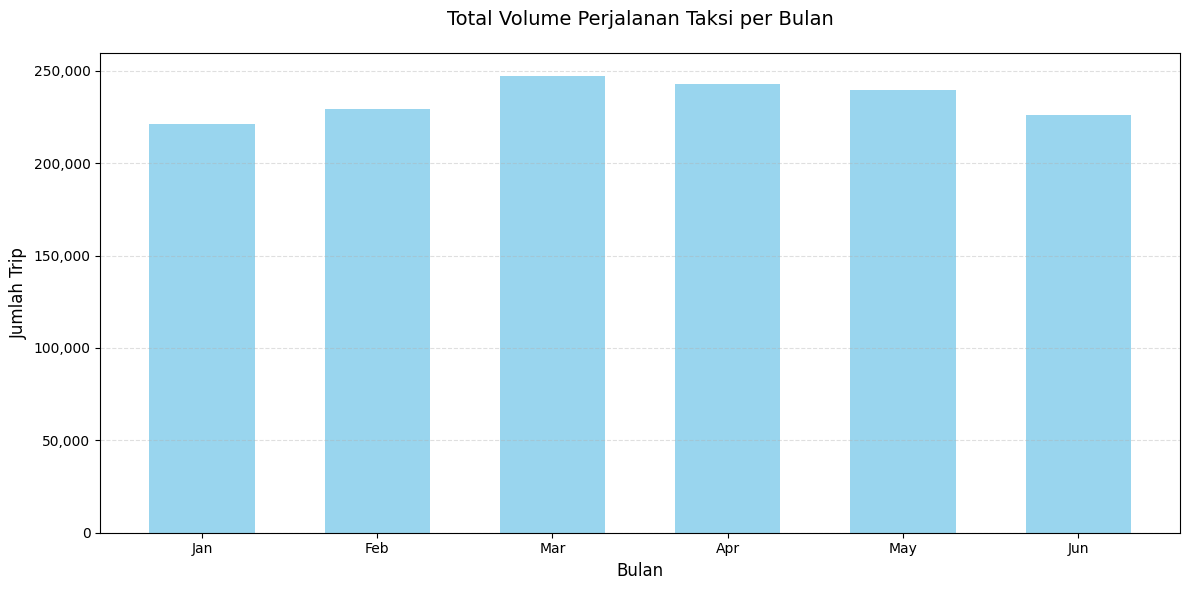

In [86]:
from pyspark.sql.functions import month, count
import calendar
import matplotlib.pyplot as plt

monthly_trips = df.withColumn("month_num", month("pickup_datetime")) \
                  .groupBy("month_num") \
                  .agg(count("*").alias("total_trips")) \
                  .orderBy("month_num") \
                  .toPandas()

month_labels = [calendar.month_abbr[i] for i in monthly_trips['month_num']]

plt.figure(figsize=(12, 6))

# Plot Bar Chart
bars = plt.bar(monthly_trips['month_num'], monthly_trips['total_trips'], 
               color='skyblue', alpha=0.85, width=0.6)

plt.title("Total Volume Perjalanan Taksi per Bulan", fontsize=14, pad=20)
plt.xlabel("Bulan", fontsize=12)
plt.ylabel("Jumlah Trip", fontsize=12)
plt.xticks(monthly_trips['month_num'], month_labels)
plt.grid(axis='y', linestyle='--', alpha=0.4)

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.tight_layout()
plt.show()

Visualisasi Boxplot Hari vs Durasi...


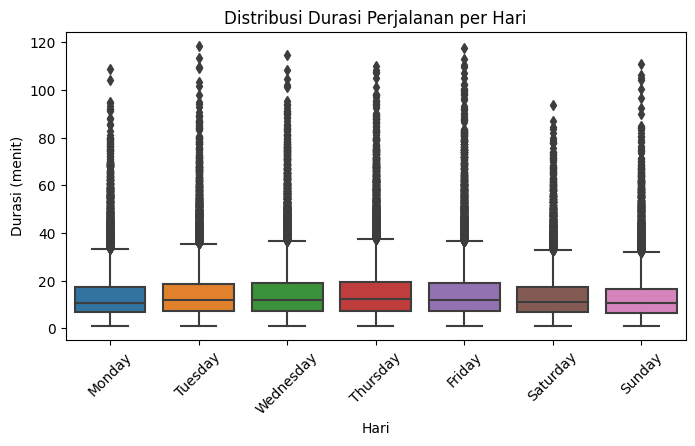

In [17]:
from pyspark.sql.functions import date_format, col

print("Visualisasi Boxplot Hari vs Durasi...")

# "EEEE" = "Monday", "Tuesday"
df = df.withColumn("pickup_dayofweek", date_format(col("pickup_datetime"), "EEEE"))

# pakai sample 10%
boxplot_data = df.select("pickup_dayofweek", "trip_duration_minutes") \
                 .sample(fraction=0.1, seed=42) \
                 .toPandas()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(8, 4))
sns.boxplot(x='pickup_dayofweek', y='trip_duration_minutes', data=boxplot_data, order=day_order)
plt.title('Distribusi Durasi Perjalanan per Hari')
plt.xlabel('Hari')
plt.ylabel('Durasi (menit)')
plt.xticks(rotation=45)
plt.show()

Visualisasi Heatmap Korelasi...


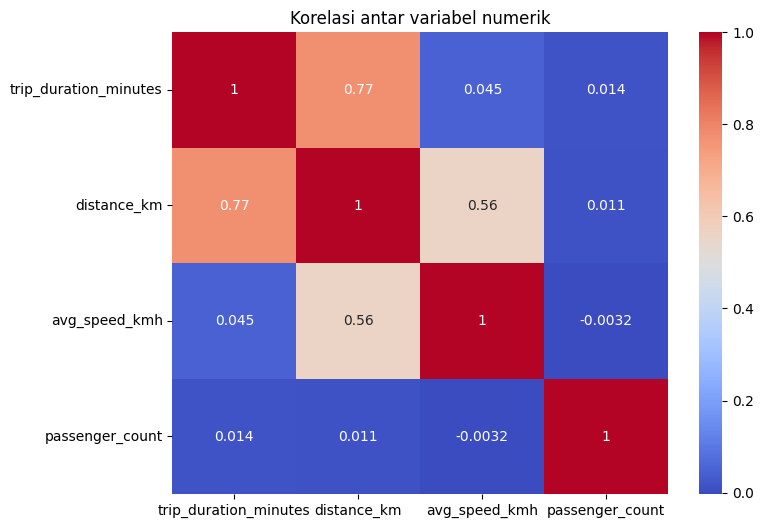

In [18]:
print("Visualisasi Heatmap Korelasi...")

numeric_cols = ['trip_duration_minutes', 'distance_km', 'avg_speed_kmh', 'passenger_count']

# Gabung jadi satu kolom vektor
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
corr_data = assembler.transform(df).select("features")

# Hitung Matriks Korelasi di Spark
pearson_corr = Correlation.corr(corr_data, "features").head()
corr_matrix = pearson_corr[0].toArray()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',
            xticklabels=numeric_cols, yticklabels=numeric_cols)
plt.title('Korelasi antar variabel numerik')
plt.show()

In [19]:
print("Visualisasi Peta Heatmap (Folium)...")


heat_data_spark = df.select("pickup_latitude", "pickup_longitude") \
                    .sample(withReplacement=False, fraction=0.007, seed=42) \
                    .collect()

heat_data_list = [[row['pickup_latitude'], row['pickup_longitude']] for row in heat_data_spark]

m = folium.Map(location=[40.75, -73.97], zoom_start=11)
HeatMap(heat_data_list, radius=10).add_to(m)

m

Visualisasi Peta Heatmap (Folium)...


In [20]:
print("Visualisasi Peta Marker Cluster...")

marker_data_spark = df.select("pickup_latitude", "pickup_longitude") \
                      .sample(withReplacement=False, fraction=0.001, seed=42) \
                      .collect()

m2 = folium.Map(location=[40.75, -73.97], zoom_start=11)
cluster = MarkerCluster().add_to(m2)

for row in marker_data_spark:
    folium.Marker([row['pickup_latitude'], row['pickup_longitude']]).add_to(cluster)

m2

Visualisasi Peta Marker Cluster...


### 4. Feature Engineering

In [91]:
print("[FE-1] Memulai Feature Engineering: Waktu...")

# Ekstraksi Komponen Waktu Dasar
df = df.withColumn("month", month(col("pickup_datetime")))
df = df.withColumn("day_of_week_idx", dayofweek(col("pickup_datetime")))
df = df.withColumn("hour", hour(col("pickup_datetime")))

# Fitur Rush Hour
from pyspark.sql.functions import when

df = df.withColumn("is_rush_hour",
                   when(col("hour").isin([8,9,10,15,16,17,18]), 1).otherwise(0))

# Fitur Weekend (Sabtu & Minggu), 1=Minggu, 7=Sabtu
df = df.withColumn("is_weekend",
                   when(col("day_of_week_idx").isin([1, 7]), 1).otherwise(0))

print("Statistik Fitur Waktu")
df.select("hour", "month", "is_weekend", "is_rush_hour").describe().show()

print("✅ Fitur Waktu Selesai.")

[FE-1] Memulai Feature Engineering: Waktu...
Statistik Fitur Waktu


+-------+------------------+-----------------+-------------------+------------------+
|summary|              hour|            month|         is_weekend|      is_rush_hour|
+-------+------------------+-----------------+-------------------+------------------+
|  count|           1406483|          1406483|            1406483|           1406483|
|   mean|13.621088203696738|3.517275359887037|0.28524553798375096|0.3448296211187764|
| stddev| 6.401204558991685|1.680685927767903|0.45153146734408034|0.4753128592275913|
|    min|                 0|                1|                  0|                 0|
|    max|                23|                6|                  1|                 1|
+-------+------------------+-----------------+-------------------+------------------+

✅ Fitur Waktu Selesai.


In [92]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from pyspark.ml.clustering import KMeans

# Gabung koordinat Pickup & Dropoff
df_pick = df.select(col("pickup_latitude").alias("lat"), col("pickup_longitude").alias("lon"))
df_drop = df.select(col("dropoff_latitude").alias("lat"), col("dropoff_longitude").alias("lon"))
df_all_coords = df_pick.union(df_drop)

# Buat Vector Input
vec_assembler = VectorAssembler(inputCols=["lat", "lon"], outputCol="features")
df_kmeans_input = vec_assembler.transform(df_all_coords)

⏳ Memulai kalkulasi Elbow Method...


   ✅ Selesai K=2 | Cost: 3,721


   ✅ Selesai K=3 | Cost: 2,285


   ✅ Selesai K=4 | Cost: 1,740


   ✅ Selesai K=5 | Cost: 1,235


   ✅ Selesai K=6 | Cost: 1,077


   ✅ Selesai K=7 | Cost: 880


   ✅ Selesai K=8 | Cost: 795


   ✅ Selesai K=9 | Cost: 774


   ✅ Selesai K=10 | Cost: 652


   ✅ Selesai K=11 | Cost: 555


   ✅ Selesai K=12 | Cost: 519


   ✅ Selesai K=13 | Cost: 481


   ✅ Selesai K=14 | Cost: 430


   ✅ Selesai K=15 | Cost: 476


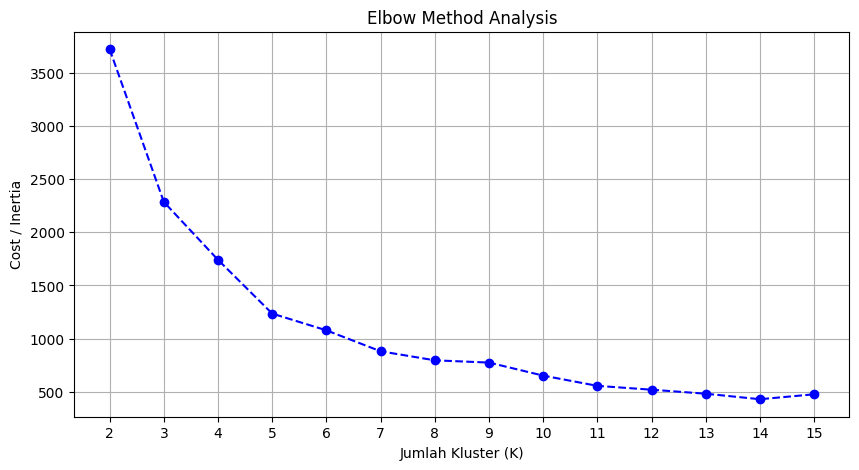

In [94]:
# Elbow Method Analysis
k_range = range(2, 16)
costs = []

print("⏳ Memulai kalkulasi Elbow Method...")

for k in k_range:
    kmeans = KMeans().setK(k).setSeed(42).setFeaturesCol("features")

    model = kmeans.fit(df_kmeans_input)

    cost = model.summary.trainingCost
    costs.append(cost)
    print(f"   ✅ Selesai K={k} | Cost: {cost:,.0f}")

plt.figure(figsize=(10, 5))
plt.plot(k_range, costs, marker='o', linestyle='--', color='blue')
plt.title('Elbow Method Analysis')
plt.xlabel('Jumlah Kluster (K)')
plt.ylabel('Cost / Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [24]:
# Final Clustering Dengan K Terbaik

K_BEST = 10

print(f"🚀 [STEP 3] Menerapkan Final KMeans dengan K={K_BEST}...")

# Training Model Final
kmeans_final = KMeans(k=K_BEST, seed=42, featuresCol="features", predictionCol="cluster")
model_km_final = kmeans_final.fit(df_kmeans_input)

# Terapkan ke Data Utama (Transform)
print("   - Mengupdate kolom cluster di DataFrame utama...")
vec_pick = VectorAssembler(inputCols=["pickup_latitude", "pickup_longitude"], outputCol="pickup_vec")
vec_drop = VectorAssembler(inputCols=["dropoff_latitude", "dropoff_longitude"], outputCol="dropoff_vec")

# Hapus kolom vektor lama
for col_name in ["pickup_vec", "dropoff_vec"]:
    if col_name in df.columns:
        df = df.drop(col_name)

df = vec_pick.transform(df)
df = vec_drop.transform(df)

# Prediksi Pickup
model_km_final.setFeaturesCol("pickup_vec")
model_km_final.setPredictionCol("pickup_cluster")
df = model_km_final.transform(df)

# Prediksi Dropoff
model_km_final.setFeaturesCol("dropoff_vec")
model_km_final.setPredictionCol("dropoff_cluster")
df = model_km_final.transform(df)

df = df.drop("pickup_vec", "dropoff_vec", "features")
print("🎉 Selesai! Dataframe sekarang punya kolom kluster yang optimal.")

🚀 [STEP 3] Menerapkan Final KMeans dengan K=10...


   - Mengupdate kolom cluster di DataFrame utama...
🎉 Selesai! Dataframe sekarang punya kolom kluster yang optimal.


In [25]:
print("🚀 [FE-3] Memulai Feature Engineering: One-Hot Encoding...")

# Encoder pakai Cluster (0-14) dan DayOfWeek (1-7)
encoder = OneHotEncoder(
    inputCols=["pickup_cluster", "dropoff_cluster", "day_of_week_idx"],
    outputCols=["pickup_cluster_vec", "dropoff_cluster_vec", "day_vec"],
    dropLast=False
)

# Fit & Transform
model_enc = encoder.fit(df)
df = model_enc.transform(df)

print("✅ Encoding Selesai. Kolom vector terbentuk: pickup_cluster_vec, dropoff_cluster_vec, day_vec")

🚀 [FE-3] Memulai Feature Engineering: One-Hot Encoding...


✅ Encoding Selesai. Kolom vector terbentuk: pickup_cluster_vec, dropoff_cluster_vec, day_vec


In [26]:
print("🚀 [FE-4] Memulai Feature Engineering: Matematika Lanjutan...")

# Delta Koordinat
df = df.withColumn("delta_lat", col("dropoff_latitude") - col("pickup_latitude"))
df = df.withColumn("delta_lon", col("dropoff_longitude") - col("pickup_longitude"))

# Manhattan Distance (Abs Delta Lat + Abs Delta Lon)
df = df.withColumn("manhattan_distance", spark_abs(col("delta_lat")) + spark_abs(col("delta_lon")))

# 3. Bearing (Arah Mata Angin)
def spark_bearing(lat1, lon1, lat2, lon2):
    lat1_r, lon1_r, lat2_r, lon2_r = to_radians(lat1), to_radians(lon1), to_radians(lat2), to_radians(lon2)
    d_lon_r = lon2_r - lon1_r

    y = sin(d_lon_r) * cos(lat2_r)
    x = cos(lat1_r) * sin(lat2_r) - sin(lat1_r) * cos(lat2_r) * cos(d_lon_r)

    # Hasil radian -> derajat -> normalisasi 0-360
    angle = to_degrees(atan2(y, x))
    return (angle + 360) % 360

df = df.withColumn("bearing", spark_bearing(
    col("pickup_latitude"), col("pickup_longitude"),
    col("dropoff_latitude"), col("dropoff_longitude")
))

# Log Distance
df = df.withColumn("log_distance", log1p(col("distance_km")))

print("--- Statistik Fitur Jarak & Arah ---")
df.select("manhattan_distance", "bearing", "log_distance").describe().show()

print("✅ Fitur Matematika Selesai.")

🚀 [FE-4] Memulai Feature Engineering: Matematika Lanjutan...
--- Statistik Fitur Jarak & Arah ---


+-------+-------------------+------------------+------------------+
|summary| manhattan_distance|           bearing|      log_distance|
+-------+-------------------+------------------+------------------+
|  count|            1406483|           1406483|           1406483|
|   mean|0.04709645011915672|153.40865605918336|1.2891111122149785|
| stddev|0.05497788917298143|103.86265751507123|0.6046542558451226|
|    min|0.00450897216796875|               0.0|0.4054652405276581|
|    max|      0.44482421875| 359.9934721638379| 3.433788640144627|
+-------+-------------------+------------------+------------------+

✅ Fitur Matematika Selesai.


In [27]:
print("🚀 [FE-5] Membuat Fitur Traffic (Rata-rata Kecepatan per Waktu & Cluster)...")

# Hitung rata-rata kecepatan berdasarkan jam dan cluster awalnya
traffic_stats = df.groupBy("hour", "pickup_cluster") \
                  .agg(avg("avg_speed_kmh").alias("expected_speed_kmh"))

df = df.join(traffic_stats, on=["hour", "pickup_cluster"], how="left")

# Hapus yg null
mean_speed_global = df.select(avg("avg_speed_kmh")).first()[0]
df = df.na.fill({"expected_speed_kmh": mean_speed_global})

print("✅ Fitur 'expected_speed_kmh' berhasil dibuat!")
df.select("hour", "pickup_cluster", "expected_speed_kmh").show(5)

🚀 [FE-5] Membuat Fitur Traffic (Rata-rata Kecepatan per Waktu & Cluster)...


✅ Fitur 'expected_speed_kmh' berhasil dibuat!


+----+--------------+------------------+
|hour|pickup_cluster|expected_speed_kmh|
+----+--------------+------------------+
|  16|             3|11.430283316769046|
|  20|             3|13.138270990146719|
|  15|             8|13.173316299229139|
|  23|             3|15.060645594320647|
|  19|             7|12.679416577718245|
+----+--------------+------------------+
only showing top 5 rows



In [28]:
print("🚀 [FE-6] Finalisasi: Transformasi Target & Cleanup...")

# Target = Log Trip Duration
df = df.withColumn("log_trip_duration", log1p(col("trip_duration_minutes")))

print("--- Statistik Target (Log Duration) ---")
df.select("trip_duration_minutes", "log_trip_duration").describe().show()

# Drop Kolom yang Tidak Dipakai Modeling
cols_to_drop = [
    'id', 'pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag',
    'trip_duration', 'avg_speed_kmh'
]

# Hapus kolom yg masih tersisa
existing_cols = df.columns
cols_to_drop_final = [c for c in cols_to_drop if c in existing_cols]
df = df.drop(*cols_to_drop_final)

print(f"Kolom dihapus: {cols_to_drop_final}")
print(f"Total Kolom Sekarang: {len(df.columns)}")
print(f"Daftar Kolom: {df.columns}")

df.cache()

🚀 [FE-6] Finalisasi: Transformasi Target & Cleanup...
--- Statistik Target (Log Duration) ---


+-------+---------------------+------------------+
|summary|trip_duration_minutes| log_trip_duration|
+-------+---------------------+------------------+
|  count|              1406483|           1406483|
|   mean|   14.228665970367102|2.5176589730699237|
| stddev|    10.84354951064774|0.6363255771066646|
|    min|                  1.0|0.6931471805599453|
|    max|   118.71666666666667| 4.785127839852701|
+-------+---------------------+------------------+

Kolom dihapus: ['id', 'pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag', 'trip_duration', 'avg_speed_kmh']
Total Kolom Sekarang: 27
Daftar Kolom: ['hour', 'pickup_cluster', 'vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_duration_minutes', 'distance_km', 'pickup_hour', 'pickup_dayofweek', 'month', 'day_of_week_idx', 'is_rush_hour', 'is_weekend', 'dropoff_cluster', 'pickup_cluster_vec', 'dropoff_cluster_vec', 'day_vec', 'delta_lat', 'delta_lon', 'manhattan_

DataFrame[hour: int, pickup_cluster: int, vendor_id: int, passenger_count: int, pickup_longitude: double, pickup_latitude: double, dropoff_longitude: double, dropoff_latitude: double, trip_duration_minutes: double, distance_km: double, pickup_hour: int, pickup_dayofweek: string, month: int, day_of_week_idx: int, is_rush_hour: int, is_weekend: int, dropoff_cluster: int, pickup_cluster_vec: vector, dropoff_cluster_vec: vector, day_vec: vector, delta_lat: double, delta_lon: double, manhattan_distance: double, bearing: double, log_distance: double, expected_speed_kmh: double, log_trip_duration: double]

In [29]:
print("--- [CHECK] 5 Baris Data Teratas (Format Spark) ---")
df.show(5)

--- [CHECK] 5 Baris Data Teratas (Format Spark) ---


+----+--------------+---------+---------------+------------------+------------------+------------------+-----------------+---------------------+------------------+-----------+----------------+-----+---------------+------------+----------+---------------+------------------+-------------------+-------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+
|hour|pickup_cluster|vendor_id|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude| dropoff_latitude|trip_duration_minutes|       distance_km|pickup_hour|pickup_dayofweek|month|day_of_week_idx|is_rush_hour|is_weekend|dropoff_cluster|pickup_cluster_vec|dropoff_cluster_vec|      day_vec|           delta_lat|           delta_lon|  manhattan_distance|           bearing|      log_distance|expected_speed_kmh| log_trip_duration|
+----+--------------+---------+---------------+------------------+------------------+------------------+--

In [30]:
# Simpan data ke file parquet

print("💾 Menyimpan hasil Preprocessing ke Disk (Parquet)...")

df.write.mode("overwrite").parquet("data_taxi_clean.parquet")

print("✅ Data tersimpan! Membaca ulang dari Parquet...")

df = spark.read.parquet("data_taxi_clean.parquet")

df.cache()

💾 Menyimpan hasil Preprocessing ke Disk (Parquet)...


✅ Data tersimpan! Membaca ulang dari Parquet...


DataFrame[hour: int, pickup_cluster: int, vendor_id: int, passenger_count: int, pickup_longitude: double, pickup_latitude: double, dropoff_longitude: double, dropoff_latitude: double, trip_duration_minutes: double, distance_km: double, pickup_hour: int, pickup_dayofweek: string, month: int, day_of_week_idx: int, is_rush_hour: int, is_weekend: int, dropoff_cluster: int, pickup_cluster_vec: vector, dropoff_cluster_vec: vector, day_vec: vector, delta_lat: double, delta_lon: double, manhattan_distance: double, bearing: double, log_distance: double, expected_speed_kmh: double, log_trip_duration: double]

In [31]:
# Export Json Centroid untuk bikin peta di web

print("📝 Export JSON Centroid...")

spark_centers = model_km_final.clusterCenters()

centroids_list = [c.tolist() for c in spark_centers]

data_centroid = {
    "pickup_clusters": centroids_list,
    "dropoff_clusters": centroids_list
}

if not os.path.exists('models'): os.makedirs('models')

with open('models/cluster_centroids.json', 'w') as f:
    json.dump(data_centroid, f, indent=4)

📝 Export JSON Centroid...


In [32]:
# Export Model PKL untuk Deployment
from sklearn.cluster import KMeans as SklearnKMeans
import numpy as np
import joblib
import os

print("💾 Menyimpan Model PKL (Sinkronisasi Spark -> Python)...")

# Pakai data Centroid terbaru dari Model Spark (K=10)
spark_centers = model_km_final.clusterCenters()
centroids_np = np.array([c.tolist() for c in spark_centers])
jumlah_k_aktual = len(centroids_np)

print(f"   ℹ️ Terdeteksi {jumlah_k_aktual} kluster dari model Spark.")

# Buat Dummy Model Scikit-Learn
sk_kmeans = SklearnKMeans(n_clusters=jumlah_k_aktual, n_init=1)

# Paksa pusat kluster Sklearn agar sama persis dengan Spark
sk_kmeans.cluster_centers_ = centroids_np
sk_kmeans._n_threads = 1

# Simpan jadi .pkl
if not os.path.exists('models'): os.makedirs('models')

joblib.dump(sk_kmeans, 'models/kmeans_pickup.pkl')
joblib.dump(sk_kmeans, 'models/kmeans_dropoff.pkl')

print(f"✅ Selesai! Model tersimpan dengan K={jumlah_k_aktual}.")

💾 Menyimpan Model PKL (Sinkronisasi Spark -> Python)...
   ℹ️ Terdeteksi 10 kluster dari model Spark.
✅ Selesai! Model tersimpan dengan K=10.


### 5. Modeling Masalah 1: Prediksi Durasi Perjalanan

In [33]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

print("🚀 [Step 1] Mengambil SEMUA FITUR VALID dari Spark ke Pandas...")

cols_valid = [
    'trip_duration_minutes', # Target
    'distance_km',           # Fitur Utama
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'bearing', 'manhattan_distance', 'log_distance',
    'hour', 'month', 'is_weekend', 'is_rush_hour', 'passenger_count',
    'day_of_week_idx'
]

# Transfer ke Pandas
pdf_reg = df.select(cols_valid).toPandas()

print(f"✅ Data Loaded: {pdf_reg.shape}")

# Preprocessing
pdf_reg.dropna(inplace=True)
pdf_reg['log_duration'] = np.log1p(pdf_reg['trip_duration_minutes'])

# Split Data
X = pdf_reg.drop(['trip_duration_minutes', 'log_duration'], axis=1)
y = pdf_reg['log_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("✅ Siap Training!")

🚀 [Step 1] Mengambil SEMUA FITUR VALID dari Spark ke Pandas...


✅ Data Loaded: (1406483, 15)
✅ Siap Training!


In [34]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def cetak_evaluasi_menit(y_true_log, y_pred_log, nama_model):
    y_true_min = np.expm1(y_true_log)
    y_pred_min = np.expm1(y_pred_log)
    
    rmse = np.sqrt(mean_squared_error(y_true_min, y_pred_min))
    mae = mean_absolute_error(y_true_min, y_pred_min)
    r2 = r2_score(y_true_min, y_pred_min)
    
    # Hitung MAPE
    mape = mean_absolute_percentage_error(y_true_min, y_pred_min)
    
    print(f"📊 {nama_model} (Real Scale)")
    print(f"   RMSE: {rmse:.4f} Menit")
    print(f"   MAE : {mae:.4f} Menit")
    print(f"   MAPE: {mape:.2%}")
    print(f"   R2  : {r2:.4f}")
    print("-" * 30)

In [35]:
print("🚀 [Python Model] Melatih Linear Regression")
lr_std = LinearRegression()
lr_std.fit(X_train, y_train)
y_pred_lr = lr_std.predict(X_test)

cetak_evaluasi_menit(y_test, y_pred_lr, "Linear Regression")

🚀 [Python Model] Melatih Linear Regression
📊 Linear Regression (Real Scale)
   RMSE: 6.3719 Menit
   MAE : 4.1124 Menit
   MAPE: 33.55%
   R2  : 0.6550
------------------------------


In [40]:
print("🚀 [Python Model] Melatih Random Forest")
rf_std = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_std.fit(X_train, y_train)
y_pred_rf = rf_std.predict(X_test)

cetak_evaluasi_menit(y_test, y_pred_rf, "Random Forest")

🚀 [Python Model] Melatih Random Forest
📊 Random Forest (Real Scale)
   RMSE: 5.1747 Menit
   MAE : 3.2388 Menit
   MAPE: 25.98%
   R2  : 0.7725
------------------------------


In [41]:
print("🚀 [Python Model] Melatih XGBoost")
xgb_std = xgb.XGBRegressor(random_state=42, n_jobs=-1)
xgb_std.fit(X_train, y_train)
y_pred_xgb = xgb_std.predict(X_test)

cetak_evaluasi_menit(y_test, y_pred_xgb, "XGBoost")

🚀 [Python Model] Melatih XGBoost
📊 XGBoost (Real Scale)
   RMSE: 4.7665 Menit
   MAE : 2.9308 Menit
   MAPE: 23.11%
   R2  : 0.8070
------------------------------


In [42]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import xgboost as xgb
import numpy as np
import time
import joblib
import os

# 1. Definisi Search Space
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'reg_alpha': [0, 1, 10],
    'reg_lambda': [1, 5]
}

xgb_model_base = xgb.XGBRegressor(
    random_state=42, 
    n_jobs=-1, 
    objective='reg:squarederror',
    tree_method='hist'
)

# 2. Eksekusi Tuning
"""
print("🚀 Mulai Hyperparameter Tuning (RandomizedSearch)...")
search = RandomizedSearchCV(
    xgb_model_base, 
    param_distributions=param_dist, 
    n_iter=10, 
    scoring='neg_root_mean_squared_error', 
    cv=3, 
    verbose=1, 
    n_jobs=-1,
    random_state=42
)
search.fit(X_train, y_train)
best_params = search.best_params_
"""

# 3. Menggunakan Best Parameters
print("⚙️ Menggunakan Best Parameters dari hasil tuning sebelumnya...")

# Parameter terbaik
best_params = {
    'n_estimators': 500,
    'max_depth': 6,
    'learning_rate': 0.2,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'reg_alpha': 1,
    'reg_lambda': 1,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'tree_method': 'hist',
    'random_state': 42
}

xgb_tuned = xgb.XGBRegressor(**best_params)

# Training
print("🚀 Melatih XGBoost Tuned...")
start_time = time.time()
xgb_tuned.fit(X_train, y_train)
print(f"✅ Training Selesai dalam {time.time() - start_time:.2f} detik.")

# 4. Evaluasi
y_pred_log = xgb_tuned.predict(X_train)

y_train_real = np.expm1(y_train)
y_pred_real = np.expm1(y_pred_log)

rmse_real = np.sqrt(mean_squared_error(y_train_real, y_pred_real))
mae_real = mean_absolute_error(y_train_real, y_pred_real)
mape_real = mean_absolute_percentage_error(y_train_real, y_pred_real)
r2_real = r2_score(y_train_real, y_pred_real)

print("\n" + "="*50)
print("🏆 HYPERPARAMETERS TERPILIH")
print("="*50)
for k, v in best_params.items():
    print(f"  🔹 {k:<20} : {v}")

print("-" * 50)
print("📊 PERFORMA MODEL")
print("-" * 50)
print(f"  📉 RMSE : {rmse_real:.4f} Menit")
print(f"  📉 MAE  : {mae_real:.4f} Menit")
print(f"  📉 MAPE : {mape_real:.2%}")
print(f"  📈 R²   : {r2_real:.5f}")
print("="*50)

⚙️ Menggunakan Best Parameters dari hasil tuning sebelumnya...
🚀 Melatih XGBoost Tuned...
✅ Training Selesai dalam 25.92 detik.

🏆 HYPERPARAMETERS TERPILIH
  🔹 n_estimators         : 500
  🔹 max_depth            : 6
  🔹 learning_rate        : 0.2
  🔹 subsample            : 0.8
  🔹 colsample_bytree     : 0.9
  🔹 reg_alpha            : 1
  🔹 reg_lambda           : 1
  🔹 objective            : reg:squarederror
  🔹 n_jobs               : -1
  🔹 tree_method          : hist
  🔹 random_state         : 42
--------------------------------------------------
📊 PERFORMA MODEL
--------------------------------------------------
  📉 RMSE : 4.4862 Menit
  📉 MAE  : 2.7384 Menit
  📉 MAPE : 21.42%
  📈 R²   : 0.82879


In [44]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import xgboost as xgb
import numpy as np
import time

print("🚀 [Step 3] Feature Selection (Protected + Top 10) & Training Ulang...")

protected_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

def robust_feature_selection(model, X_df, max_feats=10, protected=[]):
    selector = SelectFromModel(
        model, 
        threshold=-np.inf, 
        max_features=max_feats, 
        prefit=True
    )
    
    mask = selector.get_support()
    selected_features = X_df.columns[mask].tolist()
    
    forced_count = 0
    for col in protected:
        if col in X_df.columns and col not in selected_features:
            selected_features.append(col)
            forced_count += 1
            
    return X_df[selected_features], selected_features

🚀 [Step 3] Feature Selection (Protected + Top 10) & Training Ulang...


In [45]:
# 1. Seleksi Fitur
X_train_sel, selected_features = robust_feature_selection(
    xgb_tuned, 
    X_train, 
    max_feats=10, 
    protected=protected_cols
)

X_test_sel = X_test[selected_features]

print(f"   - Fitur Awal    : {X_train.shape[1]}")
print(f"   - Fitur Final   : {len(selected_features)} (Base 10 + Protected)")
print(f"   - List Fitur    : {selected_features}")

# 2. Ambil parameter dari model yang sudah dituning
best_params = xgb_tuned.get_params()

xgb_final = xgb.XGBRegressor(**best_params)

print("\n⏳ Sedang melatih Final Model (Selected Features)...")
xgb_final.fit(X_train_sel, y_train)
preds_final = xgb_final.predict(X_test_sel)

# 3. Evaluasi
print("\n" + "="*50)
print("📊 EVALUASI FINAL: MODEL TERSELEKSI")
print("="*50)

y_test_min = np.expm1(y_test)
preds_min = np.expm1(preds_final)

rmse_min = np.sqrt(mean_squared_error(y_test_min, preds_min))
mae_min = mean_absolute_error(y_test_min, preds_min)
mape_min = mean_absolute_percentage_error(y_test_min, preds_min)
r2_min = r2_score(y_test_min, preds_min)

print(f"   📉 RMSE : {rmse_min:.4f} Menit")
print(f"   📉 MAE  : {mae_min:.4f} Menit")
print(f"   📉 MAPE : {mape_min:.2%}")
print(f"   📈 R²   : {r2_min:.4f}")
print("="*50)

   - Fitur Awal    : 14
   - Fitur Final   : 11 (Base 10 + Protected)
   - List Fitur    : ['distance_km', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'bearing', 'log_distance', 'hour', 'is_weekend', 'is_rush_hour', 'day_of_week_idx', 'pickup_longitude']

⏳ Sedang melatih Final Model (Selected Features)...

📊 EVALUASI FINAL: MODEL TERSELEKSI
   📉 RMSE : 4.7336 Menit
   📉 MAE  : 2.8667 Menit
   📉 MAPE : 22.33%
   📈 R²   : 0.8096


In [46]:
import joblib
import os

print("🚀 [Step 4] Menyimpan Model Terbaik ke Disk (.pkl)...")

# Pastikan folder models ada
if not os.path.exists('models'):
    os.makedirs('models')

# 1. Simpan Model Final (XGBoost dengan Selected Features)
joblib.dump(xgb_final, 'models/xgb_problem1_final.pkl')

# 2. Simpan List Fitur (Penting untuk memastikan urutan kolom saat deployment)
joblib.dump(selected_features, 'models/features_problem1_final.pkl')

print(f"✅ Model yang dipilih: Tuned XGBoost (Protected + Top 10 Features)")
print(f"   - Jumlah Fitur: {len(selected_features)}")
print(f"   - List Fitur  : {selected_features}")

print("\n💾 SUKSES! File tersimpan:")
print("   📂 1. Model : models/xgb_problem1_final.pkl")
print("   📂 2. Fitur : models/features_problem1_final.pkl")

🚀 [Step 4] Menyimpan Model Terbaik ke Disk (.pkl)...
✅ Model yang dipilih: Tuned XGBoost (Protected + Top 10 Features)
   - Jumlah Fitur: 11
   - List Fitur  : ['distance_km', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'bearing', 'log_distance', 'hour', 'is_weekend', 'is_rush_hour', 'day_of_week_idx', 'pickup_longitude']

💾 SUKSES! File tersimpan:
   📂 1. Model : models/xgb_problem1_final.pkl
   📂 2. Fitur : models/features_problem1_final.pkl


## 6. Modeling Masalah 2: Prediksi Pergerakan / Tujuan Penumpang

In [48]:
import numpy as np
import pandas as pd

print("🚀 [Masalah 2] Menyiapkan Data untuk Klasifikasi Tujuan...")


if 'pdf' not in locals():
    print("⚠️ Variabel 'pdf' belum ditemukan. Sedang konversi dari Spark DataFrame...")
    try:
        pdf = df.toPandas()
        print(f"✅ Berhasil membuat 'pdf' dari 'df'. Ukuran: {pdf.shape}")
    except NameError:
        raise NameError("❌ Variabel 'df' (Spark) juga tidak ditemukan! Harap jalankan Cell Load Data & Unified Clustering dulu di atas.")

# Fitur Waktu Siklus (Cyclical)
if 'hour_sin' not in pdf.columns:
    print("   - Membuat fitur waktu siklus (Sin/Cos)...")
    pdf['hour_sin'] = np.sin(2 * np.pi * pdf['hour'] / 24)
    pdf['hour_cos'] = np.cos(2 * np.pi * pdf['hour'] / 24)
    pdf['month_sin'] = np.sin(2 * np.pi * pdf['month'] / 12)
    pdf['month_cos'] = np.cos(2 * np.pi * pdf['month'] / 12)

# Pilih Fitur yang Logis untuk Menebak Tujuan
features_dest = [
    'pickup_cluster',
    'passenger_count',
    'is_weekend',
    'is_rush_hour',
    'hour_sin', 'hour_cos',
    'month_sin', 'month_cos'
]

target_dest = 'dropoff_cluster'

print(f"   ✅ Fitur Terpilih ({len(features_dest)}): {features_dest}")
print(f"   🎯 Target: {target_dest}")

🚀 [Masalah 2] Menyiapkan Data untuk Klasifikasi Tujuan...
⚠️ Variabel 'pdf' belum ditemukan. Sedang konversi dari Spark DataFrame...


✅ Berhasil membuat 'pdf' dari 'df'. Ukuran: (1406483, 27)
   - Membuat fitur waktu siklus (Sin/Cos)...
   ✅ Fitur Terpilih (8): ['pickup_cluster', 'passenger_count', 'is_weekend', 'is_rush_hour', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
   🎯 Target: dropoff_cluster


In [49]:
from sklearn.model_selection import train_test_split

print("✂️ Membagi Data Train & Test khusus Masalah 2...")

X_dest = pdf[features_dest]
y_dest = pdf[target_dest].astype(int)

# Split 80% Train, 20% Test
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_dest, y_dest, test_size=0.2, random_state=42
)

print(f"   - Data Training : {len(X_train_d):,} baris")
print(f"   - Data Testing  : {len(X_test_d):,} baris")

✂️ Membagi Data Train & Test khusus Masalah 2...
   - Data Training : 1,125,186 baris
   - Data Testing  : 281,297 baris


In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time

print("🌲 [Model 1] Melatih Random Forest...")
start = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    n_jobs=-1,
    random_state=42
)
rf_model.fit(X_train_d, y_train_d)

acc_rf = accuracy_score(y_test_d, rf_model.predict(X_test_d))
print(f"   ✅ Selesai dalam {time.time() - start:.2f} detik")
print(f"   🎯 Akurasi Random Forest: {acc_rf:.2%}")

🌲 [Model 1] Melatih Random Forest...
   ✅ Selesai dalam 55.39 detik
   🎯 Akurasi Random Forest: 35.02%


In [52]:
import xgboost as xgb

print("🚀 [Model 2] Melatih XGBoost Classifier...")
start = time.time()

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=6,
    tree_method='hist',
    n_jobs=-1,
    random_state=42
)
xgb_model.fit(X_train_d, y_train_d)

acc_xgb = accuracy_score(y_test_d, xgb_model.predict(X_test_d))
print(f"   ✅ Selesai dalam {time.time() - start:.2f} detik")
print(f"   🎯 Akurasi XGBoost: {acc_xgb:.2%}")

🚀 [Model 2] Melatih XGBoost Classifier...
   ✅ Selesai dalam 90.25 detik
   🎯 Akurasi XGBoost: 35.54%


In [53]:
import lightgbm as lgb

print("💡 [Model 3] Melatih LightGBM...")
start = time.time()

lgb_std = lgb.LGBMClassifier(
    n_estimators=100,
    objective='multiclass',
    num_class=6,
    n_jobs=-1,
    random_state=42,
    verbose=-1
)
lgb_std.fit(X_train_d, y_train_d)

acc_lgb = accuracy_score(y_test_d, lgb_std.predict(X_test_d))
print(f"   ✅ Selesai dalam {time.time() - start:.2f} detik")
print(f"   🎯 Akurasi LightGBM (Std): {acc_lgb:.2%}")

💡 [Model 3] Melatih LightGBM...
   ✅ Selesai dalam 53.73 detik
   🎯 Akurasi LightGBM (Std): 35.62%


In [54]:
from sklearn.metrics import top_k_accuracy_score

all_models = {
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'LightGBM': lgb_std
}

print(f"{'Model':<15} | {'Top-1 Acc':<10} | {'Top-3 Acc':<10}")
print("-" * 45)

for name, model in all_models.items():
    y_proba = model.predict_proba(X_test_d)
    
    acc_1 = top_k_accuracy_score(y_test_d, y_proba, k=1)
    acc_3 = top_k_accuracy_score(y_test_d, y_proba, k=3)
    
    print(f"{name:<15} | {acc_1:.2%}     | {acc_3:.2%}")

Model           | Top-1 Acc  | Top-3 Acc 
---------------------------------------------
Random Forest   | 35.02%     | 77.10%
XGBoost         | 35.54%     | 77.60%
LightGBM        | 35.62%     | 77.65%


In [55]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import gc
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Bersihkan memori dari variabel lama jika ada
for var in ['model', 'lgb_train', 'lgb_eval', 'X_train', 'X_test', 'y_train', 'y_test']:
    if var in globals():
        del globals()[var]
gc.collect()

print("✅ Libraries imported & Memory cleaned.")

✅ Libraries imported & Memory cleaned.


In [56]:
target_col = 'dropoff_cluster'

feature_cols = [
    'pickup_cluster',
    'passenger_count',
    'hour', 'day_of_week',
    'month',
    'is_weekend',
    'is_rush_hour',
    'hour_sin', 'hour_cos',
    'month_sin', 'month_cos'
]

# Pastikan hanya menggunakan fitur yang tersedia di dataframe 'pdf'
available_features = [c for c in feature_cols if c in pdf.columns]
print(f"✅ Fitur yang digunakan ({len(available_features)}): {available_features}")

✅ Fitur yang digunakan (10): ['pickup_cluster', 'passenger_count', 'hour', 'month', 'is_weekend', 'is_rush_hour', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']


In [57]:
print("🔄 Menyiapkan Training & Test Set...")

X = pdf[available_features].copy()
y = pdf[target_col].copy()

# Ubah fitur kategori menjadi tipe category agar LightGBM optimal
categorical_feats = ['pickup_cluster']
for col in categorical_feats:
    if col in X.columns:
        X[col] = X[col].astype('category')

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Data Split Selesai. Train shape: {X_train.shape}, Test shape: {X_test.shape}")

del X, y
gc.collect()

🔄 Menyiapkan Training & Test Set...
✅ Data Split Selesai. Train shape: (1125186, 10), Test shape: (281297, 10)


0

In [58]:
# Buat Dataset LightGBM (Format Khusus LightGBM)
print("📦 Membuat LightGBM Dataset...")
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature='auto')
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, categorical_feature='auto')

print("✅ LightGBM Dataset siap.")

📦 Membuat LightGBM Dataset...
✅ LightGBM Dataset siap.


In [59]:
# Konfigurasi Parameter Model
num_classes = pdf[target_col].nunique()
print(f"🎯 Target Klasifikasi: {num_classes} Kluster Tujuan")

params = {
    'objective': 'multiclass',
    'num_class': num_classes,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'n_jobs': -1,
    'verbose': -1,
    'seed': 42
}

🎯 Target Klasifikasi: 10 Kluster Tujuan


In [60]:
print("🚀 Mulai Training LightGBM...")

model = lgb.train(
    params,
    lgb_train,
    num_boost_round=2000,
    valid_sets=[lgb_train, lgb_eval],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

print("✅ Training Selesai.")

🚀 Mulai Training LightGBM...
Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 1.66519	valid_1's multi_logloss: 1.66637
Early stopping, best iteration is:
[141]	training's multi_logloss: 1.66372	valid_1's multi_logloss: 1.66619
✅ Training Selesai.


In [61]:
print("\n🔍 Melakukan Evaluasi Top-3 Prediction...")

# Prediksi Probabilitas
y_pred_prob = model.predict(X_test)

# Fungsi Helper untuk Top-K Accuracy
def get_top_k_accuracy(probs, y_true, k=3):
    # Ambil indeks top-k probabilitas tertinggi
    top_k_preds = np.argsort(probs, axis=1)[:, -k:][:, ::-1]
    hits = 0
    y_true_arr = y_true.to_numpy()
    
    # Cek apakah target asli ada di dalam prediksi top-k
    for i in range(len(y_true_arr)):
        if y_true_arr[i] in top_k_preds[i]:
            hits += 1
    return hits / len(y_true_arr)

# Hitung Metrik
acc_top1 = accuracy_score(y_test, np.argmax(y_pred_prob, axis=1))
acc_top3 = get_top_k_accuracy(y_pred_prob, y_test, k=3)

print(f"\n📊 HASIL EVALUASI FINAL:")
print(f"   -----------------------")
print(f"   🏆 Top-1 Accuracy : {acc_top1:.2%}")
print(f"   🥉 Top-3 Accuracy : {acc_top3:.2%}")
print(f"   -----------------------")


🔍 Melakukan Evaluasi Top-3 Prediction...

📊 HASIL EVALUASI FINAL:
   -----------------------
   🏆 Top-1 Accuracy : 35.74%
   🥉 Top-3 Accuracy : 77.78%
   -----------------------


In [62]:
if not os.path.exists('models'): os.makedirs('models')

# Simpan Model
joblib.dump(model, 'models/lgbm_destination_prediction.pkl')
print("\n💾 Model disimpan: 'models/lgbm_destination_prediction.pkl'")

# Simpan Nama Fitur (PENTING untuk deployment)
final_features = model.feature_name()
joblib.dump(final_features, 'models/features_problem2_final.pkl')
print(f"💾 Fitur disimpan: 'models/features_problem2_final.pkl'")
print(f" Total {len(final_features)} fitur: {final_features}")


💾 Model disimpan: 'models/lgbm_destination_prediction.pkl'
💾 Fitur disimpan: 'models/features_problem2_final.pkl'
 Total 10 fitur: ['pickup_cluster', 'passenger_count', 'hour', 'month', 'is_weekend', 'is_rush_hour', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']


In [65]:
print("\n📋 Contoh Output Prediksi:")

sample_indices = range(5)
top_3_idx = np.argsort(y_pred_prob, axis=1)[:, -3:][:, ::-1]

for i in sample_indices:
    actual = y_test.iloc[i]
    print(f"\n🚖 Penumpang #{i+1}")
    print(f"   📍 Asal Kluster : {X_test.iloc[i]['pickup_cluster']}")
    print(f"   🏁 Tujuan Asli  : Kluster {actual}")
    print(f"   🔮 Prediksi     :")

    for rank in range(3):

        pred_cluster = top_3_idx[i][rank]
        prob = y_pred_prob[i][pred_cluster] * 100
        marker = "✅" if pred_cluster == actual else "  "
        print(f"{rank+1}. Kluster {pred_cluster} ({prob:.1f}%) {marker}")


📋 Contoh Output Prediksi:

🚖 Penumpang #1
   📍 Asal Kluster : 1.0
   🏁 Tujuan Asli  : Kluster 7
   🔮 Prediksi     :
1. Kluster 1 (36.3%)   
2. Kluster 7 (23.8%) ✅
3. Kluster 8 (15.0%)   

🚖 Penumpang #2
   📍 Asal Kluster : 1.0
   🏁 Tujuan Asli  : Kluster 1
   🔮 Prediksi     :
1. Kluster 7 (39.9%)   
2. Kluster 1 (31.1%) ✅
3. Kluster 3 (10.5%)   

🚖 Penumpang #3
   📍 Asal Kluster : 0.0
   🏁 Tujuan Asli  : Kluster 0
   🔮 Prediksi     :
1. Kluster 3 (30.9%)   
2. Kluster 0 (27.2%) ✅
3. Kluster 7 (14.3%)   

🚖 Penumpang #4
   📍 Asal Kluster : 0.0
   🏁 Tujuan Asli  : Kluster 7
   🔮 Prediksi     :
1. Kluster 3 (30.7%)   
2. Kluster 0 (24.2%)   
3. Kluster 7 (15.2%) ✅

🚖 Penumpang #5
   📍 Asal Kluster : 7.0
   🏁 Tujuan Asli  : Kluster 5
   🔮 Prediksi     :
1. Kluster 7 (41.8%)   
2. Kluster 3 (24.9%)   
3. Kluster 1 (13.3%)   


In [63]:
import pandas as pd

# Cek Jumlah Trip Per Cluster (Urutkan dari yang terbanyak)
cluster_counts = pdf['pickup_cluster'].value_counts().sort_index()

print("Total Trips per Cluster")
print(cluster_counts)

Total Trips per Cluster
pickup_cluster
0    189270
1    198005
2     31262
3    390548
4     14197
5     40210
6     12809
7    425113
8    100232
9      4837
Name: count, dtype: int64


In [68]:
import json
import pandas as pd
from pyspark.sql.functions import col, count, avg

print("📊 [Notebook] Menghitung Statistik Kluster (Speed & Passenger)...")

# 1. Pastikan kolom kecepatan sudah ada
if "avg_speed_kmh" not in df.columns:
    df = df.withColumn("avg_speed_kmh", col("distance_km") / (col("trip_duration_minutes") / 60))

# 2. Agregasi Data Dasar
stats_basic = df.groupBy("pickup_cluster").agg(
    count("*").alias("count"),
    avg("trip_duration_minutes").alias("avg_duration"),
    avg("avg_speed_kmh").alias("avg_speed"),
    avg("passenger_count").alias("avg_passenger")
).toPandas()

# 3. Mencari Peak Time
hourly_counts = df.groupBy("pickup_cluster", "hour").count().toPandas()
peak_hours = hourly_counts.loc[hourly_counts.groupby("pickup_cluster")["count"].idxmax()]
peak_hours = peak_hours[["pickup_cluster", "hour"]].set_index("pickup_cluster")

# 4. Format Data ke Dictionary JSON
stats_dict = {}

for _, row in stats_basic.iterrows():
    cluster_id = int(row['pickup_cluster'])
    
    # Format Peak Time
    peak_h = int(peak_hours.loc[cluster_id]['hour'])
    peak_time_str = f"{peak_h:02d}:00 - {peak_h+1:02d}:00"
    
    stats_dict[str(cluster_id)] = {
        "avg_trips": f"{int(row['count']):,} trips",
        "avg_duration": f"{int(row['avg_duration'])} min",
        "avg_speed": f"{row['avg_speed']:.1f} km/h",
        "avg_pax": f"{row['avg_passenger']:.1f} org",
        "peak_time": peak_time_str
    }

# 5. Simpan
if not os.path.exists('models'): os.makedirs('models')
with open('models/cluster_stats.json', 'w') as f:
    json.dump(stats_dict, f, indent=4)

print("✅ Statistik (Speed & Pax) tersimpan di 'models/cluster_stats.json'")

📊 [Notebook] Menghitung Statistik Kluster (Speed & Passenger)...


✅ Statistik (Speed & Pax) tersimpan di 'models/cluster_stats.json'


In [69]:
spark.stop()